In [1]:
import numpy as np
from numpy import sqrt, exp
import cmath

def characteristic_impedance(R, L, G, C, f):
    """Compute characteristic impedance Z0 = sqrt((R+jwL)/(G+jwC))."""
    w = 2*np.pi*f
    Z0 = cmath.sqrt((R + 1j*w*L) / (G + 1j*w*C))
    return Z0

def propagation_constant(R, L, G, C, f):
    """Compute propagation constant gamma = alpha + j*beta = sqrt((R+jwL)*(G+jwC))."""
    w = 2*np.pi*f
    gamma = cmath.sqrt((R + 1j*w*L) * (G + 1j*w*C))
    return gamma

def input_impedance(Z0, gamma, ZL, length):
    """
    Compute input impedance for a line of length 'length' with load ZL:
    Zin = Z0 * (ZL + Z0*tanh(gamma*length)) / (Z0 + ZL*tanh(gamma*length)).
    """
    # Use tanh for complex argument
    tanh_gl = cmath.tanh(gamma * length)
    Zin = Z0 * (ZL + Z0 * tanh_gl) / (Z0 + ZL * tanh_gl)
    return Zin

def reflection_coefficient(Z0, ZL):
    """Voltage reflection coefficient at the load: (ZL - Z0) / (ZL + Z0)."""
    return (ZL - Z0) / (ZL + Z0)

def vswr_from_gamma(Gamma):
    """Voltage Standing Wave Ratio from reflection coefficient magnitude."""
    mag = abs(Gamma)
    if mag >= 1.0:
        return np.inf
    return (1 + mag) / (1 - mag)

def phase_velocity(L, C, beta):
    """
    Phase velocity v_p = omega / beta.
    For lossless or near-lossless lines: v_p = 1/sqrt(L*C):contentReference[oaicite:13]{index=13}:contentReference[oaicite:14]{index=14}.
    """
    return 2*np.pi*freq / beta  # if beta computed by propagation_constant

def wavelength(beta):
    """Wavelength lambda = 2*pi / beta."""
    return 2*np.pi / beta

def propagation_delay(length, vp):
    """One-way propagation delay tau = length / vp."""
    return length / vp

# Example usage and test for a lossless line
R, L_, G, C_ = 0, 2e-6, 0, 50e-12  # per-unit-length (ohm/m, H/m, S/m, F/m)
freq = 100e6  # frequency 100 MHz
Z0 = characteristic_impedance(R, L_, G, C_, freq)
gamma = propagation_constant(R, L_, G, C_, freq)
alpha, beta = gamma.real, gamma.imag

print(f"Z0 (lossless) = {Z0:.2f} Ω (should be real √(L/C)={np.sqrt(L_/C_):.2f})")
print(f"Propagation constant γ = {gamma}  (α={alpha:.2e}, β={beta:.2e})")


Z0 (lossless) = 200.00+0.00j Ω (should be real √(L/C)=200.00)
Propagation constant γ = 6.283185307179585j  (α=0.00e+00, β=6.28e+00)


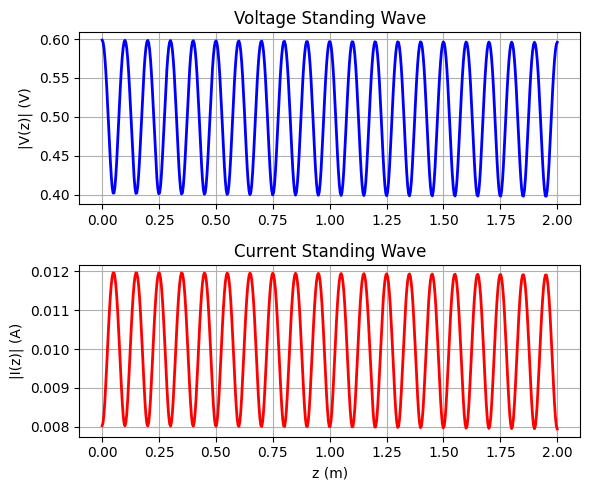

In [19]:
import matplotlib.pyplot as plt

def plot_standing_waves(R,L,G,C,f,l,ZL,Vs=1.0,Zs=50.0,num=500):
    """Plot |V(z)| and |I(z)| along the line for given parameters."""
    Z0 = characteristic_impedance(R,L,G,C,f)
    gamma = propagation_constant(R,L,G,C,f)
    Zin = input_impedance(Z0, gamma, ZL, l)

    Vin = Vs * (Zin / (Zs + Zin))
    Iin = Vin / Zin

    a = (Vin + Z0*Iin)/2
    b = (Vin - Z0*Iin)/2

    z = np.linspace(0, l, num)
    Vz = a*np.exp(-gamma*z) + b*np.exp(gamma*z)
    Iz = (a/Z0)*np.exp(-gamma*z) - (b/Z0)*np.exp(gamma*z)

    plt.figure(figsize=(6,5))
    plt.subplot(2,1,1)
    plt.plot(z, np.abs(Vz), 'b', lw=2)
    plt.ylabel('|V(z)| (V)')
    plt.title('Voltage Standing Wave')
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(z, np.abs(Iz), 'r', lw=2)
    plt.ylabel('|I(z)| (A)')
    plt.xlabel('z (m)')
    plt.title('Current Standing Wave')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: 2 m line, 1 GHz, load 75Ω, source 1V, 50Ω internal
plot_standing_waves(
    R=0.1, L=250e-9, G=1e-4, C=100e-12,
    f=1e9, l=2, ZL=75, Vs=1, Zs=50
)



In [31]:
import pandas as pd
np.random.seed(0)

def safe_vswr(Gamma, cap=1000):
    mag = abs(Gamma)
    if mag >= 0.999999:  # avoid inf
        return cap
    return (1 + mag) / (1 - mag)

def safe_divide(num, den, default=0):
    return num/den if den != 0 else default

def generate_data(n_samples=200):
    data = []
    for _ in range(n_samples):
        if np.random.rand() < 0.5:
            R = np.random.uniform(0, 5)       # lossy case
            G = np.random.uniform(1e-4, 1e-2)
        else:
            R = np.random.uniform(0, 0.1)     # almost lossless
            G = np.random.uniform(0, 1e-5)

        R = np.random.uniform(0, 5)
        L = 10**np.random.uniform(-8, -5)
        G = np.random.uniform(0, 1e-3)
        C = 10**np.random.uniform(-12, -10)
        f = np.random.uniform(1e6, 1e9)
        ZL_mag = np.random.uniform(10,100)
        ZL_phase = np.random.uniform(-np.pi, np.pi)
        ZL = ZL_mag * np.exp(1j*ZL_phase)

        Z0 = characteristic_impedance(R, L, G, C, f)
        gamma = propagation_constant(R, L, G, C, f)
        Zin = input_impedance(Z0, gamma, ZL, length=1.0)
        Gamma = reflection_coefficient(Z0, ZL)

        VSWR = np.log1p(safe_vswr(Gamma))            # capped
        beta = gamma.imag
        vp   = np.log1p(safe_divide(2*np.pi*f, beta))
        lam  = np.log1p(safe_divide(2*np.pi, beta))
        tau  = np.log1p(safe_divide(1.0, vp))

        row = [
            R, L, G, C, f, ZL.real, ZL.imag,
            Z0.real, Z0.imag, gamma.real, beta,
            Zin.real, Zin.imag, Gamma.real, Gamma.imag,
            VSWR, vp, lam, tau
        ]
        # replace any nan/inf with 0 (or you can skip row)
        row = [0 if (np.isnan(v) or np.isinf(v)) else v for v in row]
        data.append(row)

    cols = ['R','L','G','C','f','ZL_real','ZL_imag',
            'Z0_real','Z0_imag','alpha','beta',
            'Zin_real','Zin_imag','Gamma_real','Gamma_imag',
            'VSWR','v_p','lambda','tau']
    return pd.DataFrame(data, columns=cols)



In [32]:
df = generate_data(2000)
print(np.any(np.isinf(df.values)), np.any(np.isnan(df.values)))


False False


In [33]:

# input and output columns
features = df[['R','L','G','C','f','ZL_real','ZL_imag']].values
targets  = df[['Z0_real','Z0_imag','alpha','beta']].values

target_columns = ['Z0_real','Z0_imag','alpha','beta']



In [34]:
df['alpha'] = np.log1p(df['alpha'])
df['Z0_imag'] = np.sign(df['Z0_imag']) * np.log1p(np.abs(df['Z0_imag']))


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Prepare data for PyTorch
from sklearn.model_selection import train_test_split
features = df[['R','L','G','C','f','ZL_real','ZL_imag']].values
targets  = df[['Z0_real','Z0_imag','alpha','beta']].values
target_columns = ['Z0_real','Z0_imag','alpha','beta']


X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=1)


def sgnlog(x):
    return np.sign(x) * np.log1p(np.abs(x))

def inv_sgnlog(y):
    return np.sign(y) * (np.expm1(np.abs(y)))

# Transform Z0_imag column (index 1) in both train and test
y_train[:, 1] = sgnlog(y_train[:, 1])
y_test[:, 1]  = sgnlog(y_test[:, 1])


# Normalize
scaler_in = StandardScaler().fit(X_train)
scaler_out = StandardScaler().fit(y_train)
X_train_n = scaler_in.transform(X_train)
X_test_n = scaler_in.transform(X_test)
y_train_n = scaler_out.transform(y_train)
y_test_n = scaler_out.transform(y_test)

# PyTorch dataset and dataloader
train_tensor = torch.tensor(X_train_n, dtype=torch.float32)
target_tensor = torch.tensor(y_train_n, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(train_tensor, target_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Define a simple MLP
class TLNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(7, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 4)
        )
    def forward(self, x):
        return self.net(x)

model = TLNet(input_dim=7, output_dim=4)

optimizer = optim.Adam(model.parameters(), lr=5e-5)

weights = torch.tensor([1.0, 5.0, 1.0, 1.0])  # [Z0_real, Z0_imag, alpha, beta]
# if using GPU, add .to(train_tensor.device)

def weighted_mse(pred, target):
    return ((pred - target)**2 * weights).mean()

criterion = weighted_mse


# Training loop
for epoch in range(3000):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    # optionally evaluate on test every 100 epochs
    if epoch % 200 == 0:
        model.eval()
        with torch.no_grad():
            pred_test = model(torch.tensor(X_test_n, dtype=torch.float32)).numpy()
        r2 = r2_score(y_test_n, pred_test)
        print(f"Epoch {epoch}: test R2 = {r2:.4f}")

# Final evaluation in original scale
# Final evaluation in original scale
model.eval()
y_pred_n = model(torch.tensor(X_test_n, dtype=torch.float32)).detach().numpy()
y_pred_t = scaler_out.inverse_transform(y_pred_n)  # still in sgnlog space for imag
y_pred = y_pred_t.copy()
y_true = y_test.copy()

# Invert the Z0_imag transform back to linear scale
y_pred[:, 1] = inv_sgnlog(y_pred_t[:, 1])
y_true[:, 1] = inv_sgnlog(y_test[:, 1])

# Compute R² scores
r2_all = r2_score(y_true, y_pred)
print(f"Final test R^2 (all outputs): {r2_all:.4f}")

for i, name in enumerate(target_columns):
    print(f"{name}: R2 = {r2_score(y_true[:, i], y_pred[:, i]):.3f}")




Epoch 0: test R2 = 0.0352
Epoch 200: test R2 = 0.9223
Epoch 400: test R2 = 0.9423
Epoch 600: test R2 = 0.9484
Epoch 800: test R2 = 0.9508
Epoch 1000: test R2 = 0.9521
Epoch 1200: test R2 = 0.9525
Epoch 1400: test R2 = 0.9516
Epoch 1600: test R2 = 0.9528
Epoch 1800: test R2 = 0.9527
Epoch 2000: test R2 = 0.9523
Epoch 2200: test R2 = 0.9522
Epoch 2400: test R2 = 0.9527
Epoch 2600: test R2 = 0.9521
Epoch 2800: test R2 = 0.9525
Final test R^2 (all outputs): 0.9567
Z0_real: R2 = 0.966
Z0_imag: R2 = 0.898
alpha: R2 = 0.970
beta: R2 = 0.992


In [43]:
# Example reconstruction for the first test sample
sample_idx = 0
Z0r, Z0i, alpha, beta = y_pred[sample_idx]

Z0_pred = Z0r + 1j*Z0i
gamma_pred = alpha + 1j*beta

# Recover original inputs (for f, ZL, length)
x_original = scaler_in.inverse_transform(X_test_n[sample_idx].reshape(1, -1))[0]
R, L, G, C, f, ZL_real, ZL_imag = x_original
ZL = ZL_real + 1j*ZL_imag
length = 1.0   # same length you used in data generation

# Derived parameters
Gamma_pred = reflection_coefficient(Z0_pred, ZL)
VSWR_pred  = (1+abs(Gamma_pred))/(1-abs(Gamma_pred))
vp_pred    = 2*np.pi*f / beta if beta != 0 else 0
lam_pred   = 2*np.pi / beta if beta != 0 else 0
tau_pred   = length / vp_pred if vp_pred != 0 else 0

print("\n--- Reconstructed Parameters ---")
print(f"Γ_pred   = {Gamma_pred:.4f}")
print(f"VSWR     = {VSWR_pred:.3f}")
print(f"vp_pred  = {vp_pred:.3e} m/s")
print(f"λ_pred   = {lam_pred:.3e} m")
print(f"τ_pred   = {tau_pred:.3e} s")



--- Reconstructed Parameters ---
Γ_pred   = -1.7148+0.7891j
VSWR     = -3.253
vp_pred  = 4.322e+09 m/s
λ_pred   = 1.180e+01 m
τ_pred   = 2.314e-10 s


In [44]:
# --- Ground truth for the same sample ---
Z0_true   = (y_test[sample_idx,0] + 1j*y_test[sample_idx,1])
alpha_t   = y_test[sample_idx,2]
beta_t    = y_test[sample_idx,3]
gamma_true = alpha_t + 1j*beta_t

Gamma_true = reflection_coefficient(Z0_true, ZL)
VSWR_true  = (1+abs(Gamma_true))/(1-abs(Gamma_true))
vp_true    = 2*np.pi*f / beta_t if beta_t != 0 else 0
lam_true   = 2*np.pi / beta_t if beta_t != 0 else 0
tau_true   = length / vp_true if vp_true != 0 else 0

print("\n--- Ground truth ---")
print(f"Γ_true   = {Gamma_true:.4f}")
print(f"VSWR     = {VSWR_true:.3f}")
print(f"vp_true  = {vp_true:.3e} m/s")
print(f"λ_true   = {lam_true:.3e} m")
print(f"τ_true   = {tau_true:.3e} s")

# Simple % errors for report
def pct_err(pred, true):
    return 0.0 if true == 0 else abs((pred-true)/true)*100

print("\n--- Percent errors (this sample) ---")
print(f"|Z0|: {pct_err(abs(Z0_pred), abs(Z0_true)):.2f}%")
print(f"alpha: {pct_err(alpha, alpha_t):.2f}%   beta: {pct_err(beta, beta_t):.2f}%")
print(f"|Γ|: {pct_err(abs(Gamma_pred), abs(Gamma_true)):.2f}%   VSWR: {pct_err(VSWR_pred, VSWR_true):.2f}%")
print(f"vp: {pct_err(vp_pred, vp_true):.2f}%   λ: {pct_err(lam_pred, lam_true):.2f}%   τ: {pct_err(tau_pred, tau_true):.2f}%")



--- Ground truth ---
Γ_true   = -1.6575+0.6861j
VSWR     = -3.519
vp_true  = 4.330e+09 m/s
λ_true   = 1.183e+01 m
τ_true   = 2.310e-10 s

--- Percent errors (this sample) ---
|Z0|: 8.06%
alpha: 7.32%   beta: 0.19%
|Γ|: 5.23%   VSWR: 7.56%
vp: 0.19%   λ: 0.19%   τ: 0.19%


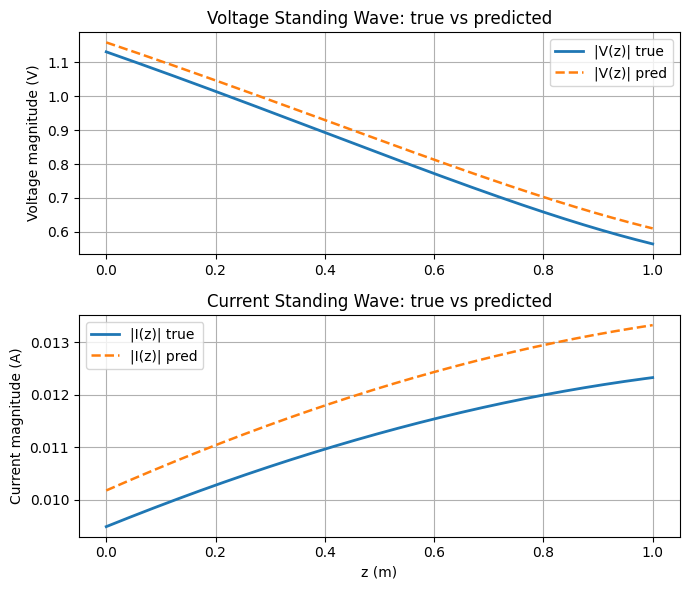

In [45]:
def plot_standing_waves_compare(Z0_true, gamma_true, Z0_pred, gamma_pred, ZL, length, Vs=1.0, Zs=50.0, num=600):
    z = np.linspace(0, length, num)

    def waves(Z0, gamma):
        # input impedance at z=0
        Zin = input_impedance(Z0, gamma, ZL, length)
        Vin = Vs * (Zin / (Zs + Zin))
        Iin = Vin / Zin
        a = (Vin + Z0*Iin)/2
        b = (Vin - Z0*Iin)/2
        Vz = a*np.exp(-gamma*z) + b*np.exp(gamma*z)
        Iz = (a/Z0)*np.exp(-gamma*z) - (b/Z0)*np.exp(gamma*z)
        return np.abs(Vz), np.abs(Iz)

    V_true, I_true = waves(Z0_true, gamma_true)
    V_pred, I_pred = waves(Z0_pred, gamma_pred)

    plt.figure(figsize=(7,6))
    plt.subplot(2,1,1)
    plt.plot(z, V_true, lw=2, label='|V(z)| true')
    plt.plot(z, V_pred, lw=1.8, linestyle='--', label='|V(z)| pred')
    plt.ylabel('Voltage magnitude (V)')
    plt.title('Voltage Standing Wave: true vs predicted')
    plt.grid(True); plt.legend()

    plt.subplot(2,1,2)
    plt.plot(z, I_true, lw=2, label='|I(z)| true')
    plt.plot(z, I_pred, lw=1.8, linestyle='--', label='|I(z)| pred')
    plt.ylabel('Current magnitude (A)')
    plt.xlabel('z (m)')
    plt.title('Current Standing Wave: true vs predicted')
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()

# Call it for your sample_idx defined above
plot_standing_waves_compare(
    Z0_true, gamma_true, Z0_pred, gamma_pred, ZL, length, Vs=1.0, Zs=50.0
)


In [47]:
# Print true vs predicted for a few test samples
n_show = 5   # how many samples to print
print("\n--- True vs Predicted values for sample cases ---")
for idx in range(n_show):
    Z0r_t, Z0i_t, alpha_t, beta_t = y_true[idx]
    Z0r_p, Z0i_p, alpha_p, beta_p = y_pred[idx]

    print(f"\nSample {idx}:")
    print(f"  Z0_real: true={Z0r_t:.4f}, pred={Z0r_p:.4f}")
    print(f"  Z0_imag: true={Z0i_t:.4e}, pred={Z0i_p:.4e}")
    print(f"  alpha  : true={alpha_t:.4e}, pred={alpha_p:.4e}")
    print(f"  beta   : true={beta_t:.4e}, pred={beta_p:.4e}")



--- True vs Predicted values for sample cases ---

Sample 0:
  Z0_real: true=132.1952, pred=121.5391
  Z0_imag: true=1.6330e+00, pred=6.2536e-01
  alpha  : true=4.2773e-02, pred=3.9644e-02
  beta   : true=5.3134e-01, pred=5.3233e-01

Sample 1:
  Z0_real: true=636.1651, pred=610.2144
  Z0_imag: true=2.6801e+00, pred=2.6372e+00
  alpha  : true=1.2872e-01, pred=1.2372e-01
  beta   : true=6.3819e+00, pred=4.7825e+00

Sample 2:
  Z0_real: true=431.5455, pred=423.9830
  Z0_imag: true=2.4654e-01, pred=2.9312e-01
  alpha  : true=2.9635e-02, pred=3.2228e-02
  beta   : true=3.5754e+01, pred=3.5584e+01

Sample 3:
  Z0_real: true=719.1318, pred=733.5073
  Z0_imag: true=2.6431e+00, pred=2.6311e+00
  alpha  : true=2.3496e-01, pred=2.3873e-01
  beta   : true=1.4398e+01, pred=1.4378e+01

Sample 4:
  Z0_real: true=551.0056, pred=547.5674
  Z0_imag: true=1.7617e+00, pred=1.8817e+00
  alpha  : true=1.9587e-01, pred=2.0186e-01
  beta   : true=2.3873e+01, pred=2.3776e+01


In [48]:
for idx in range(n_show):
    Z0r_p, Z0i_p, alpha_p, beta_p = y_pred[idx]
    Z0_pred = Z0r_p + 1j*Z0i_p
    gamma_pred = alpha_p + 1j*beta_p

    Z0r_t, Z0i_t, alpha_t, beta_t = y_true[idx]
    Z0_true = Z0r_t + 1j*Z0i_t
    gamma_true = alpha_t + 1j*beta_t

    # inputs
    x_original = scaler_in.inverse_transform(X_test_n[idx].reshape(1, -1))[0]
    f = x_original[4]
    ZL = x_original[5] + 1j*x_original[6]
    length = 1.0

    # derived
    Gamma_t = reflection_coefficient(Z0_true, ZL)
    Gamma_p = reflection_coefficient(Z0_pred, ZL)
    VSWR_t = (1+abs(Gamma_t))/(1-abs(Gamma_t))
    VSWR_p = (1+abs(Gamma_p))/(1-abs(Gamma_p))
    vp_t = 2*np.pi*f / beta_t
    vp_p = 2*np.pi*f / beta_p

    print(f"\nSample {idx}:")
    print(f"  Z0_real: true={Z0_true.real:.4f}, pred={Z0_pred.real:.4f}")
    print(f"  Z0_imag: true={Z0_true.imag:.4e}, pred={Z0_pred.imag:.4e}")
    print(f"  alpha  : true={alpha_t:.4e}, pred={alpha_p:.4e}")
    print(f"  beta   : true={beta_t:.4e}, pred={beta_p:.4e}")
    print(f"  |Gamma|: true={abs(Gamma_t):.4f}, pred={abs(Gamma_p):.4f}")
    print(f"  VSWR   : true={VSWR_t:.3f}, pred={VSWR_p:.3f}")
    print(f"  vp     : true={vp_t:.3e}, pred={vp_p:.3e}")



Sample 0:
  Z0_real: true=132.1952, pred=121.5391
  Z0_imag: true=1.6330e+00, pred=6.2536e-01
  alpha  : true=4.2773e-02, pred=3.9644e-02
  beta   : true=5.3134e-01, pred=5.3233e-01
  |Gamma|: true=1.7898, pred=1.8877
  VSWR   : true=-3.532, pred=-3.253
  vp     : true=4.330e+09, pred=4.322e+09

Sample 1:
  Z0_real: true=636.1651, pred=610.2144
  Z0_imag: true=2.6801e+00, pred=2.6372e+00
  alpha  : true=1.2872e-01, pred=1.2372e-01
  beta   : true=6.3819e+00, pred=4.7825e+00
  |Gamma|: true=0.7671, pred=0.7584
  VSWR   : true=7.589, pred=7.280
  vp     : true=1.431e+08, pred=1.909e+08

Sample 2:
  Z0_real: true=431.5455, pred=423.9830
  Z0_imag: true=2.4654e-01, pred=2.9312e-01
  alpha  : true=2.9635e-02, pred=3.2228e-02
  beta   : true=3.5754e+01, pred=3.5584e+01
  |Gamma|: true=0.6719, pred=0.6670
  VSWR   : true=5.095, pred=5.006
  vp     : true=1.011e+08, pred=1.016e+08

Sample 3:
  Z0_real: true=719.1318, pred=733.5073
  Z0_imag: true=2.6431e+00, pred=2.6311e+00
  alpha  : true=2.

In [49]:
import pandas as pd

n_show = 5  # number of samples to display
rows = []
for idx in range(n_show):
    rows.append({
        "Sample": idx,
        "Z0_real_true":  y_true[idx,0],
        "Z0_real_pred":  y_pred[idx,0],
        "Z0_imag_true":  y_true[idx,1],
        "Z0_imag_pred":  y_pred[idx,1],
        "alpha_true":    y_true[idx,2],
        "alpha_pred":    y_pred[idx,2],
        "beta_true":     y_true[idx,3],
        "beta_pred":     y_pred[idx,3],
    })

df_comp = pd.DataFrame(rows)
print("\n--- True vs Predicted fundamentals (first 5 samples) ---")
print(df_comp.round(4))

# Optional: save to CSV for your report
df_comp.to_csv("fundamentals_true_vs_pred.csv", index=False)



--- True vs Predicted fundamentals (first 5 samples) ---
   Sample  Z0_real_true  Z0_real_pred  Z0_imag_true  Z0_imag_pred  alpha_true  \
0       0      132.1952    121.539101        1.6330        0.6254      0.0428   
1       1      636.1651    610.214417        2.6801        2.6372      0.1287   
2       2      431.5455    423.983002        0.2465        0.2931      0.0296   
3       3      719.1318    733.507202        2.6431        2.6311      0.2350   
4       4      551.0056    547.567383        1.7617        1.8817      0.1959   

   alpha_pred  beta_true  beta_pred  
0      0.0396     0.5313   0.532300  
1      0.1237     6.3819   4.782500  
2      0.0322    35.7539  35.583698  
3      0.2387    14.3982  14.377900  
4      0.2019    23.8728  23.775801  


In [50]:
import joblib

# Save PyTorch model
torch.save(model.state_dict(), "txline_model.pth")

# Save scalers
joblib.dump((scaler_in, scaler_out), "scalers.pkl")
print("✅ Model and scalers saved to disk")


✅ Model and scalers saved to disk


In [51]:
import joblib
import torch

# Load scalers
scaler_in, scaler_out = joblib.load("scalers.pkl")

# Define the model architecture again
class TLNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128), torch.nn.ReLU(),
            torch.nn.Linear(128, 256), torch.nn.ReLU(),
            torch.nn.Linear(256, 128), torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Match input_dim and output_dim with your training
input_dim = 7   # [R, L, G, C, f, ZL_real, ZL_imag]
output_dim = 4  # [Z0_real, Z0_imag, alpha, beta]

# Load trained weights
model = TLNet(input_dim, output_dim)
model.load_state_dict(torch.load("txline_model.pth"))
model.eval()
print("✅ Model and scalers loaded")


✅ Model and scalers loaded


In [53]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 116.0 MB/s eta 0:00:00


In [55]:
!pip install streamlit pyngrok


In [56]:
from pyngrok import ngrok
ngrok.set_auth_token("32HNwKUiGbpTyTfo1FffsfPI3Qn_76pRx2pwvTb7FTrUKSaQR")


In [57]:
%%writefile txline_app.py
import streamlit as st
import numpy as np
import torch
import matplotlib.pyplot as plt
import joblib

# --- Load scalers and model ---
scaler_in, scaler_out = joblib.load("scalers.pkl")

class TLNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128), torch.nn.ReLU(),
            torch.nn.Linear(128, 256), torch.nn.ReLU(),
            torch.nn.Linear(256, 128), torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim)
        )
    def forward(self, x): return self.net(x)

input_dim, output_dim = 7, 4
model = TLNet(input_dim, output_dim)
model.load_state_dict(torch.load("txline_model.pth", map_location=torch.device('cpu')))
model.eval()

def reflection_coefficient(Z0, ZL): return (ZL - Z0) / (ZL + Z0)
def input_impedance(Z0, gamma, ZL, l): return Z0 * (ZL + Z0*np.tanh(gamma*l))/(Z0 + ZL*np.tanh(gamma*l))

def plot_standing_waves(Z0, gamma, ZL, length, Vs=1.0, Zs=50.0, num=500):
    z = np.linspace(0, length, num)
    Zin = input_impedance(Z0, gamma, ZL, length)
    Vin = Vs * (Zin/(Zs+Zin))
    Iin = Vin/Zin
    a, b = (Vin+Z0*Iin)/2, (Vin-Z0*Iin)/2
    Vz = a*np.exp(-gamma*z)+b*np.exp(gamma*z)
    Iz = (a/Z0)*np.exp(-gamma*z)-(b/Z0)*np.exp(gamma*z)
    fig, ax = plt.subplots(2,1,figsize=(7,6))
    ax[0].plot(z, np.abs(Vz), 'b'); ax[0].set_ylabel('|V(z)| (V)')
    ax[1].plot(z, np.abs(Iz), 'r'); ax[1].set_ylabel('|I(z)| (A)'); ax[1].set_xlabel('z (m)')
    st.pyplot(fig)

st.title("Transmission Line Predictor")
R = st.sidebar.number_input("R (Ω/m)", 0.0, 5.0, 0.1)
L = st.sidebar.number_input("L (H/m)", 1e-9, 1e-6, 250e-9, format="%.1e")
G = st.sidebar.number_input("G (S/m)", 0.0, 1e-2, 1e-4, format="%.1e")
C = st.sidebar.number_input("C (F/m)", 1e-12, 1e-9, 100e-12, format="%.1e")
f = st.sidebar.number_input("Frequency (Hz)", 1e6, 1e10, 1e9, format="%.1e")
ZL_real = st.sidebar.number_input("Load Resistance (Ω)", -200.0, 200.0, 75.0)
ZL_imag = st.sidebar.number_input("Load Reactance (Ω)", -200.0, 200.0, 0.0)
length = st.sidebar.number_input("Line length (m)", 0.1, 10.0, 2.0)

if st.sidebar.button("Predict & Plot"):
    params = np.array([R,L,G,C,f,ZL_real,ZL_imag]).reshape(1,-1)
    x_n = scaler_in.transform(params)
    x_tensor = torch.tensor(x_n, dtype=torch.float32)
    with torch.no_grad(): y_pred_n = model(x_tensor).numpy()
    y_pred = scaler_out.inverse_transform(y_pred_n)[0]
    Z0r,Z0i,alpha,beta = y_pred
    Z0, gamma, ZL = Z0r+1j*Z0i, alpha+1j*beta, ZL_real+1j*ZL_imag
    Gamma = reflection_coefficient(Z0, ZL)
    VSWR  = (1+abs(Gamma))/(1-abs(Gamma))
    vp, lam, tau = 2*np.pi*f/beta, 2*np.pi/beta, length/(2*np.pi*f/beta)
    st.write(f"Z0 = {Z0r:.3f} + j{Z0i:.3f}")
    st.write(f"alpha = {alpha:.3e}, beta = {beta:.3e}")
    st.write(f"|Gamma| = {abs(Gamma):.4f}, VSWR = {VSWR:.3f}")
    st.write(f"vp = {vp:.3e} m/s, λ = {lam:.3e} m, τ = {tau:.3e} s")
    plot_standing_waves(Z0, gamma, ZL, length)


Writing txline_app.py


In [58]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)  # Streamlit runs on 8501 by default
print("Streamlit URL:", public_url)

!streamlit run txline_app.py --server.port 8501 &>/dev/null&


Streamlit URL: NgrokTunnel: "https://dcb25cc7fc02.ngrok-free.app" -> "http://localhost:8501"
